# **Hybrid Multi-Objective Metaheuristic Machine Learning for Pandemic Modeling Using Weights from SHAPPI (Part 3)**

### Import Libraries

In [ ]:
!pip install pyswarms
!pip install sklearn-genetic
!pip install shap
!pip install -U pymoo
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.2 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=c914c1f2ad59bc46710695308944eaaff6099ecd949d8f23b949b63c2ad9c7b6
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d8846986

In [ ]:
import pandas as pd
import numpy as np
import random

import pyswarms as ps
import pyswarms.backend as ps_back
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from statistics import mean
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn.metrics import explained_variance_score,r2_score,median_absolute_error,mean_squared_error,mean_absolute_error
from matplotlib.colors import LogNorm
from sklearn.linear_model import LogisticRegression
from lime.lime_tabular import LimeTabularExplainer

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import metrics

from genetic_selection import GeneticSelectionCV

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.brkga import BRKGA
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.util.running_metric import RunningMetricAnimation
from pymoo.util.running_metric import RunningMetric

from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.core.mutation import Mutation

from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.visualization.scatter import Scatter
from pymoo.termination import get_termination
from pymoo.core.problem import Problem

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

### Initialize & Declaration of Variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# set working folder of Google Drive
folder_drive = '/content/drive/MyDrive/Dokument S3 Bismillah/Data/'

### Load Data

In [ ]:
import joblib

data_saved = joblib.load(folder_drive + 'data_saved2.job')

X = data_saved['X']
regrY1 = data_saved['regrY1']
regrY2 = data_saved['regrY2']
regrY3 = data_saved['regrY3']
regrY4 = data_saved['regrY4']
regrY5 = data_saved['regrY5']
regrY6 = data_saved['regrY6']
n_dim_X_features = data_saved['n_dim_X_features']
n_dim_Y_features = data_saved['n_dim_Y_features']
X_features_name = data_saved['X_features_name']
Y_features_name = data_saved['Y_features_name']

# bobot masing-masing Y yang didapat dari perhitungan SHAPPI
Y1_weights = data_saved['Y1_shappi_weights']
Y2_weights = data_saved['Y2_shappi_weights']
Y3_weights = data_saved['Y3_shappi_weights']
Y4_weights = data_saved['Y4_shappi_weights']
Y5_weights = data_saved['Y5_shappi_weights']
Y6_weights = data_saved['Y6_shappi_weights']

#**Define problem for Multi-Object Optimization**

Parameter Masukan
w:

Faktor skalar (weighting factor).
Parameter ini digunakan untuk mengatur tingkat pengaruh fungsi objektif secara keseluruhan.

sorted_X:
Nilai fitur (features) yang sudah diurutkan berdasarkan tingkat pentingnya (importance) menurut model.
Merupakan hasil dari proses evaluasi seperti Mean Decrease in Impurity (MDI) atau TreeSHAP.

sorted_names:
Nama fitur yang diurutkan berdasarkan kepentingannya.
Ini memberikan referensi ke fitur tertentu untuk digunakan dalam perhitungan bobot.

weight_dict:
Sebuah kamus (dictionary) yang memetakan setiap fitur ke nilai bobot (weight) yang dihitung dari gabungan analisis SHAP dan Permutation Importance (PI).
Bobot ini menunjukkan seberapa besar kontribusi setiap fitur terhadap fungsi objektif.

Logika Fungsi Menghitung Kontribusi Fitur:
a, b, c, d, e dihitung dengan mengalikan bobot fitur dari weight_dict dengan nilai masing-masing fitur dari sorted_X.

Menggabungkan Kontribusi Fitur:
Semua kontribusi fitur (a + b + c + d + e) dijumlahkan untuk mendapatkan total kontribusi.

Skalakan dengan Faktor w:
Hasil penjumlahan dikalikan dengan faktor skalar w untuk menghasilkan nilai akhir fungsi objektif (F).

Mengembalikan Nilai Akhir:
Fungsi mengembalikan nilai F, yang digunakan dalam proses optimasi (seperti NSGA-II) untuk mengevaluasi solusi tertentu.
Konteks Penggunaan
Fungsi ini berperan dalam mengukur kualitas solusi selama proses optimasi. Berdasarkan skrip sebelumnya:

Fungsi ini digunakan dalam kelas Problem_Multi2, yang mendefinisikan masalah multi-objective optimization.

Proses optimasi bertujuan untuk menemukan kombinasi optimal dari fitur input (X) dengan memperhatikan bobot fitur yang dihitung berdasarkan analisis SHAP dan PI.

Hasil dari fungsi ini (F) merupakan nilai fungsi objektif untuk tiap dimensi (objektif). Misalnya:

Objective 1: Meminimalkan tingkat pertumbuhan kasus positif.
Objective 2: Meminimalkan tingkat kematian.
Dan seterusnya.
Dalam konteks NSGA-II, nilai F digunakan untuk:

Mengevaluasi solusi-solusi dalam populasi.
Mengarahkan algoritma untuk menghasilkan solusi yang lebih baik dalam iterasi berikutnya.

In [ ]:
class Problem_Multi2(Problem):
    def __init__(self, X, Y1_weights, Y2_weights, Y3_weights, Y4_weights, Y5_weights, Y6_weights, n_dim_X_features, n_dim_Y_features):
        # Define lower and upper bounds for constraints based on the calculated bounds
        self.lower_bounds = 0  # Lower Bound (xl)
        self.upper_bounds = np.max(X, axis=0) # Lower Upper (xu)

        # Initialize the superclass with constraints for xl and xu
        super().__init__(
            n_var=n_dim_X_features,
            n_obj=n_dim_Y_features,
            xl=self.lower_bounds,
            xu=self.upper_bounds
        )

        self.Y1_weights = Y1_weights
        self.Y2_weights = Y2_weights
        self.Y3_weights = Y3_weights
        self.Y4_weights = Y4_weights
        self.Y5_weights = Y5_weights
        self.Y6_weights = Y6_weights

    def _set_func(self, x, weights):
        val_x = []
        i = 0
        for key, value in weights.items():
            valx = value * x[:, i]
            val_x.append(valx)
            i += 1

        F = np.sum(val_x, axis=0)
        return F

    def _evaluate(self, x, out, *args, **kwargs):

        fY1 = self._set_func(x, self.Y1_weights)
        fY2 = self._set_func(x, self.Y2_weights)
        fY3 = self._set_func(x, self.Y3_weights)
        fY4 = self._set_func(x, self.Y4_weights)
        fY5 = self._set_func(x, self.Y5_weights)
        fY6 = self._set_func(x, self.Y6_weights)

        out["F"] = np.column_stack([fY1, fY2, fY3, fY4, fY5, fY6])


##**Multi-Objective Optimization (MOO) using NSGA-II**

In [ ]:
def MOO_NSGA2(problem):
  # Multi-Objective Optimization using NSGA-II
  termination = get_termination("n_gen", 100)

  algorithm = NSGA2(pop_size=500,
                    n_offsprings=50,
                    sampling=FloatRandomSampling(),
                    crossover=SBX(prob=0.5, eta=15),
                    mutation=PM(eta=20),
                    eliminate_duplicates=True
                    )

  res = minimize(problem,
                algorithm,
                termination,
                seed=1,
                save_history=True,
                verbose=True)

  return res

In [ ]:
import time
start_time = time.time()

problem_multi = Problem_Multi2(X, Y1_weights, Y2_weights, Y3_weights, Y4_weights, Y5_weights, Y6_weights, n_dim_X_features, n_dim_Y_features)
res = MOO_NSGA2(problem_multi)

end_time = time.time()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      500 |      1 |             - |             -
     2 |      550 |      1 |  0.000000E+00 |             f
     3 |      600 |      1 |  0.000000E+00 |             f
     4 |      650 |      1 |  0.000000E+00 |             f
     5 |      700 |      2 |  1.0000000000 |         ideal
     6 |      750 |      2 |  0.000000E+00 |             f
     7 |      800 |      3 |  0.2642766385 |         ideal
     8 |      850 |      3 |  0.6006546833 |         ideal
     9 |      900 |      2 |  1.0000000000 |         ideal
    10 |      950 |      2 |  0.000000E+00 |             f
    11 |     1000 |      2 |  2.4375187889 |         ideal
    12 |     1050 |      2 |  0.2319885011 |         ideal
    13 |     1100 |      2 |  0.000000E+00 |             f
    14 |     1150 |      4 |  0.7365186439 |         ideal
    15 |     1200 |      5 |  0.1047566740 |         ideal
    16 |     1250 |      2 |  3.7323123561 |         ide

In [ ]:
execution_time = end_time - start_time
print(f"Computation Time: {execution_time:.4f} sec")

Computation Time: 11.1258 sec


In [ ]:
# Logging helper to diagnose fitness values
import logging
logging.basicConfig(level=logging.INFO)
def log_population(population, gen):
    logging.info(f"Generation {gen} fitness values: {[ind.F for ind in population]}")

/usr/local/lib/python3.11/dist-packages/pymoo/termination/ftol.py:14: RuntimeWarning: invalid value encountered in divide
  return np.max(np.abs((a - b) / norm))


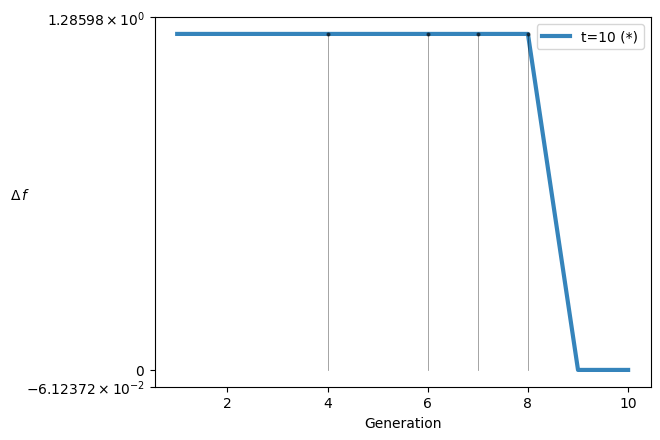

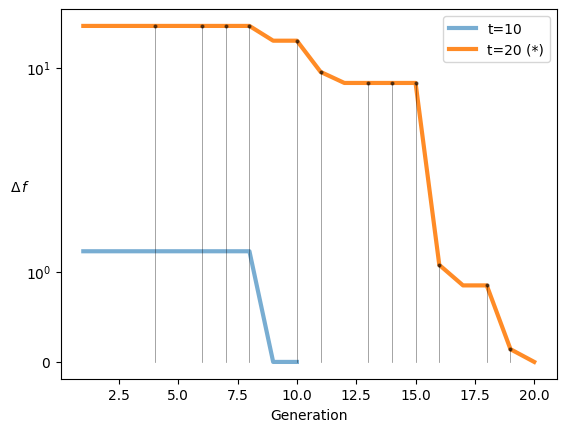

/usr/local/lib/python3.11/dist-packages/pymoo/termination/ftol.py:14: RuntimeWarning: divide by zero encountered in divide
  return np.max(np.abs((a - b) / norm))


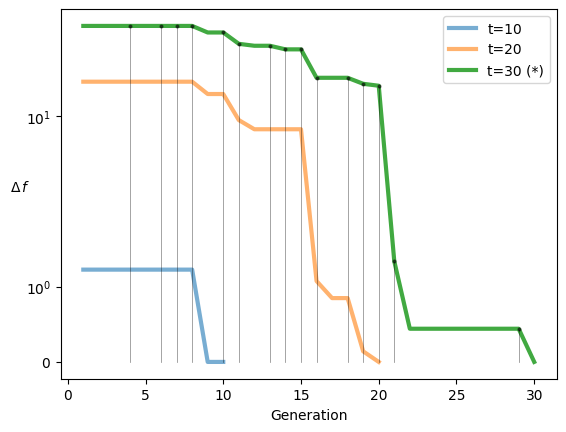

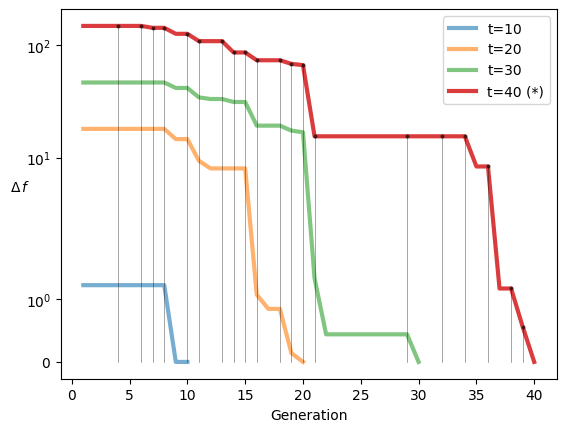

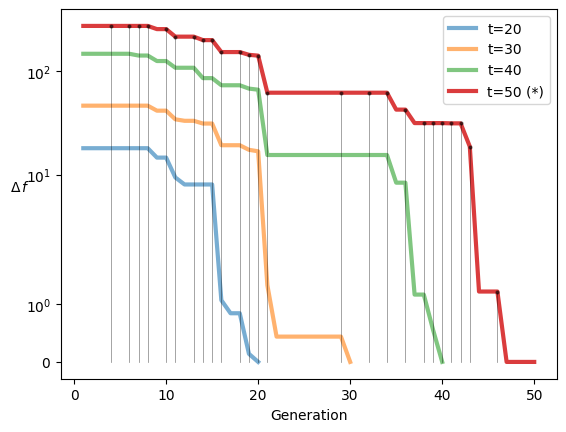

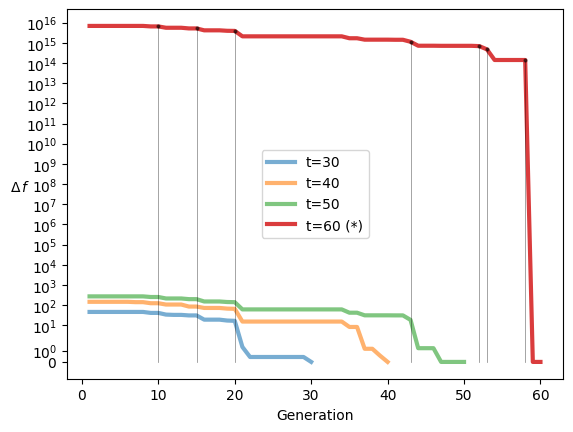

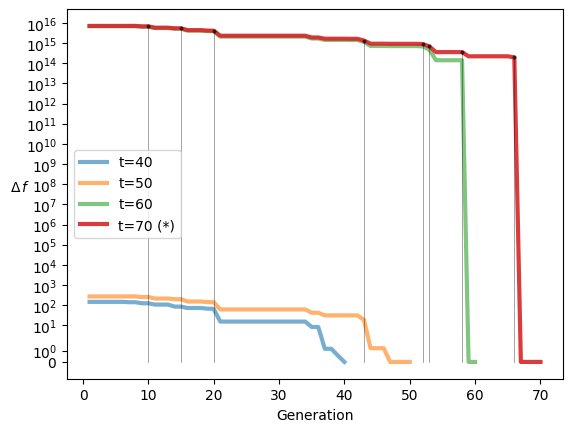

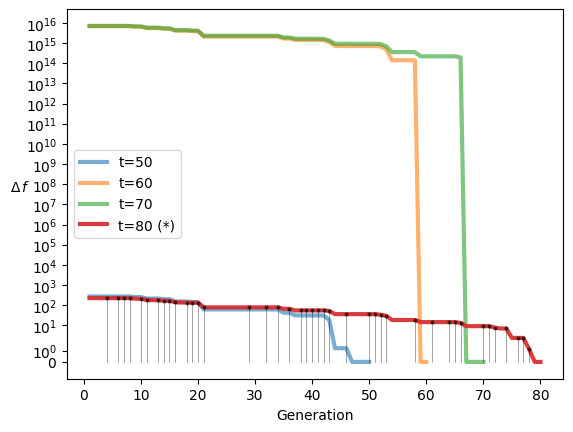

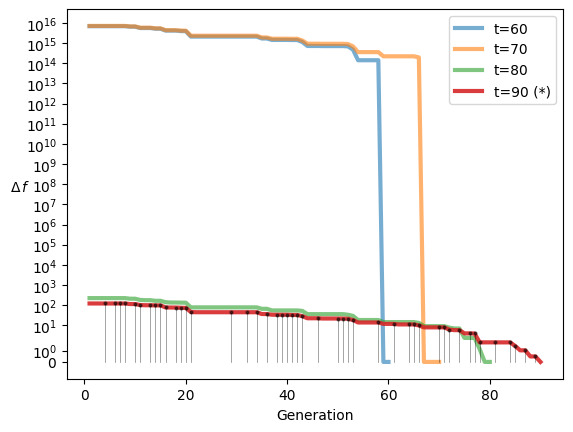

In [ ]:
running = RunningMetricAnimation(delta_gen=10,
                        n_plots=4,
                        key_press=False,
                        do_show=True)

for algorithm in res.history[:-1]:
    running.update(algorithm)

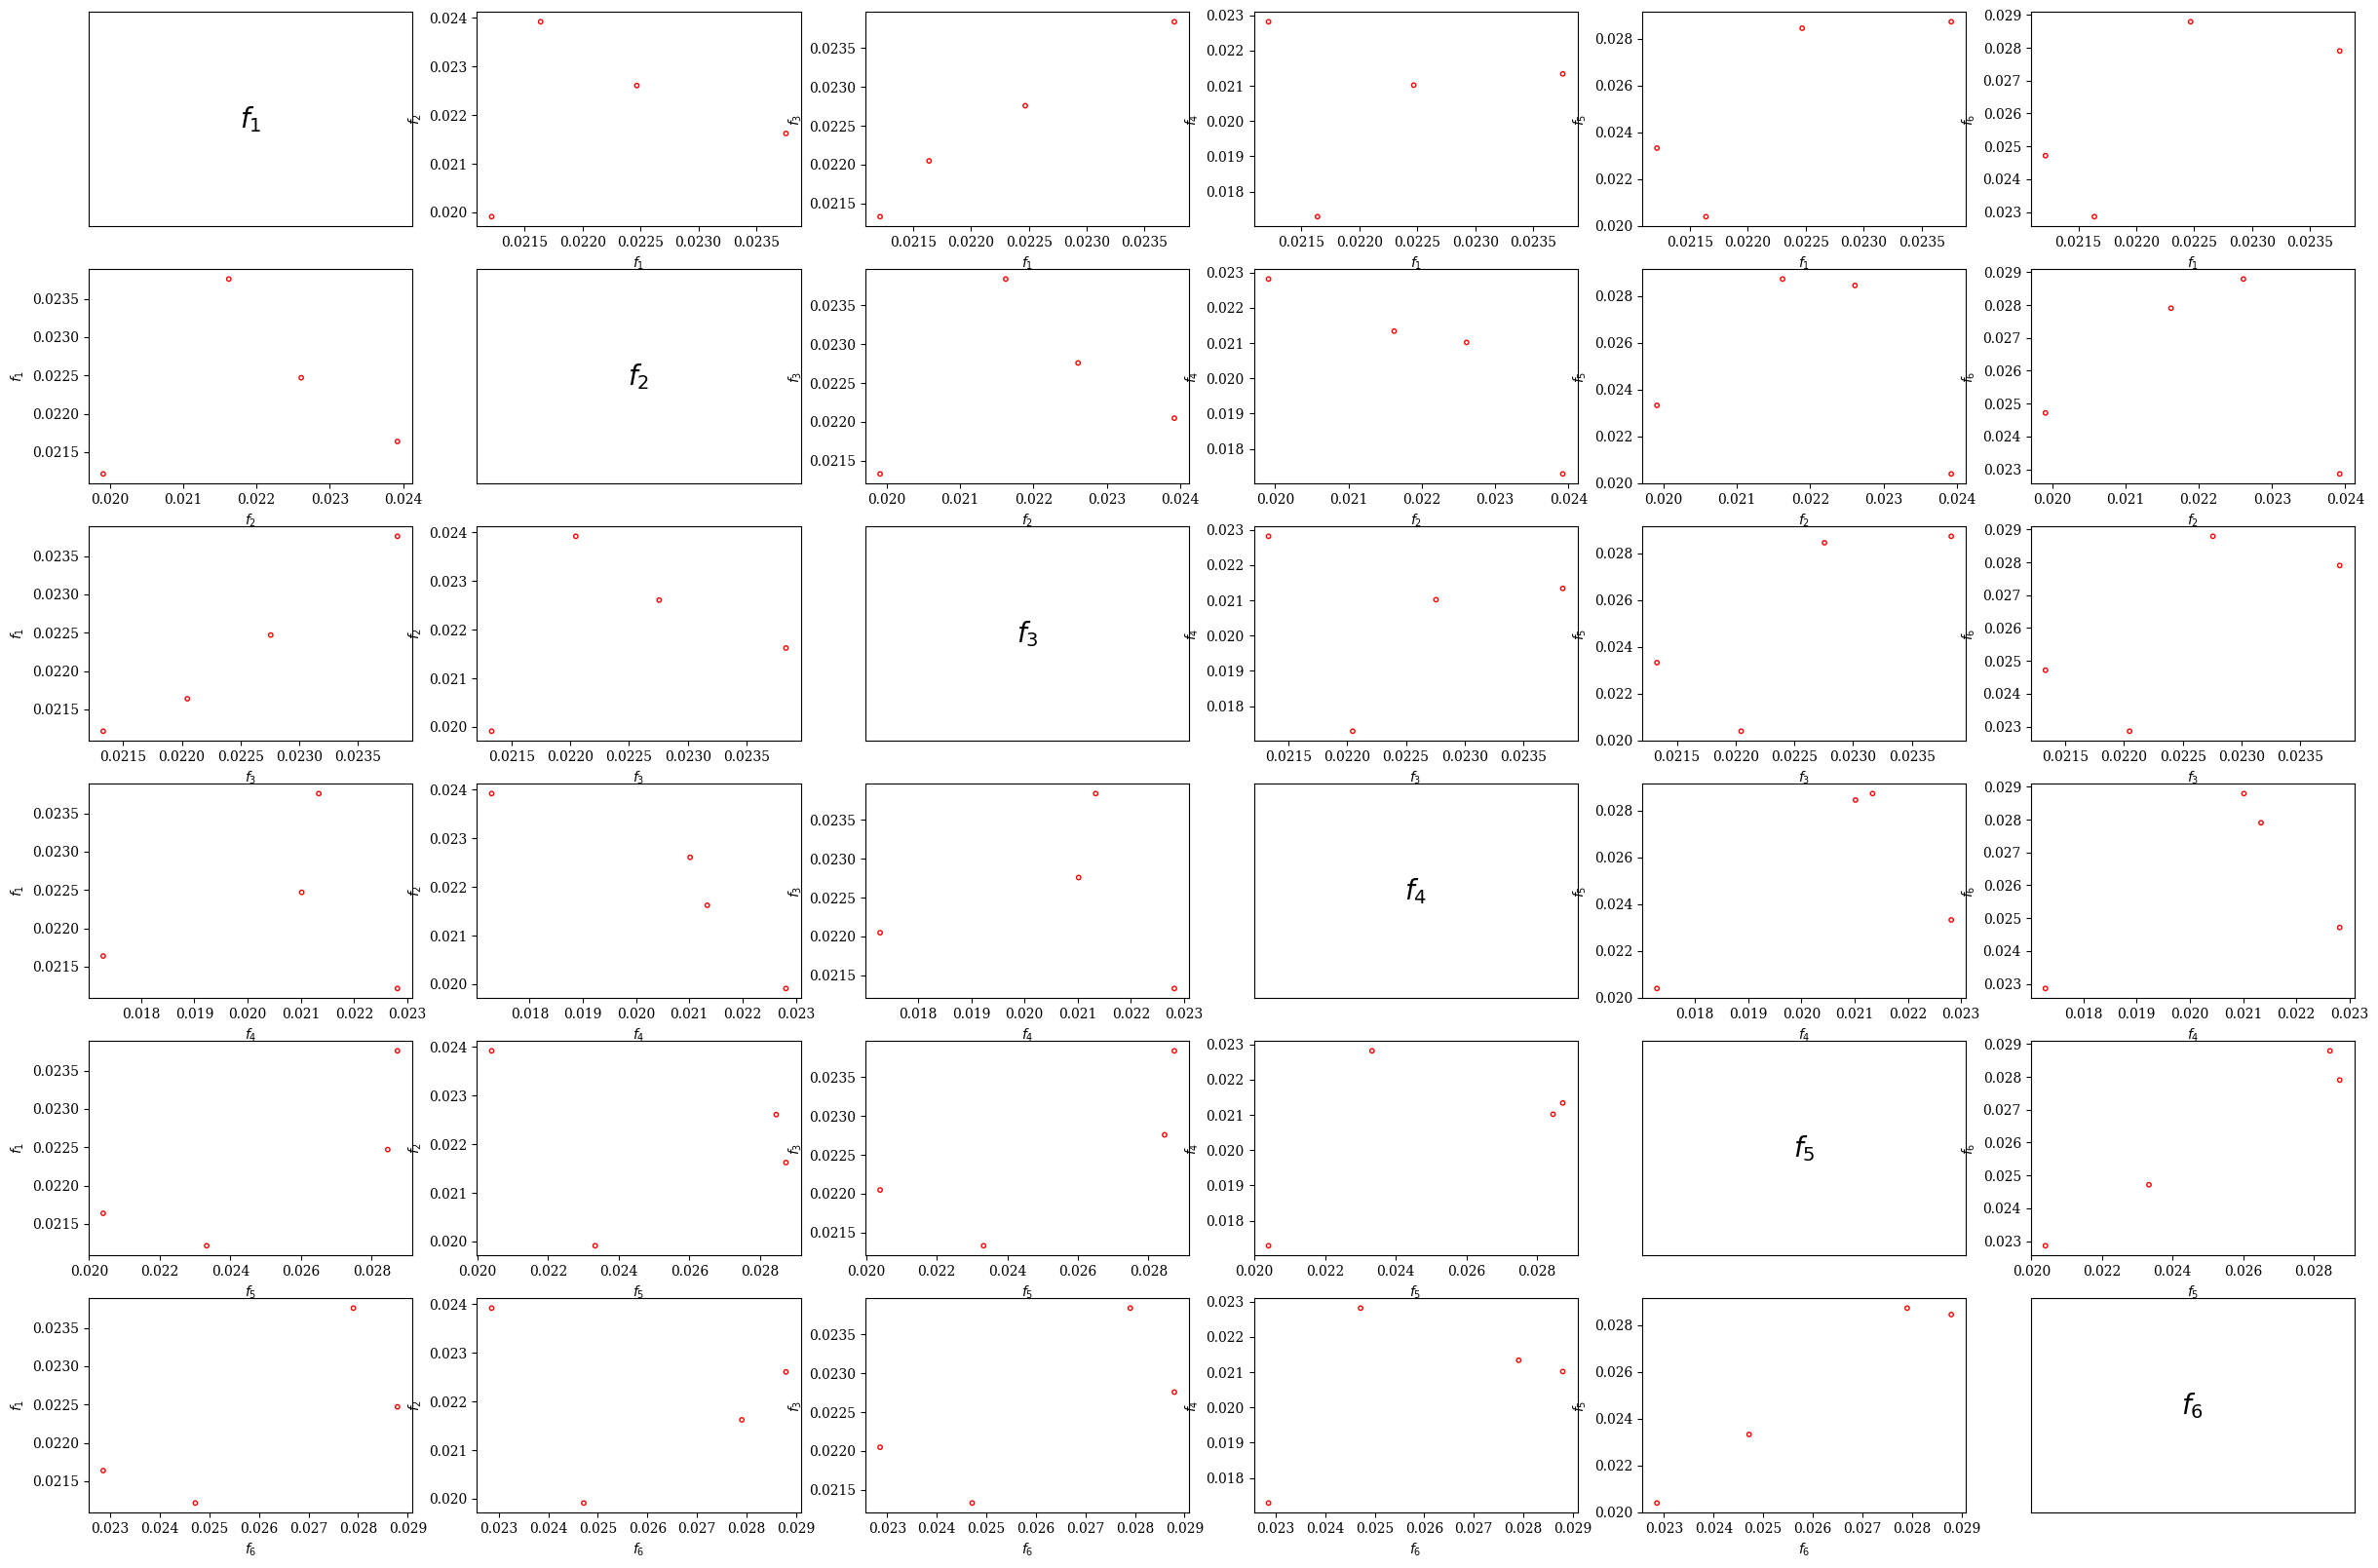

In [ ]:
# f1 to f2 represent the two objective functions, which are the daily growth rate of confrmed cases and the daily death rate, respectively (Y. Pan et al., 2021, p. 12)
plot = Scatter(figsize=(30, 20))
plot.add(problem_multi.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red", s=10)

plot.show()

In [ ]:
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

Best solution found: 
X = [[1.85142408e-03 3.81089325e-03 1.44350151e-02 2.56250696e-02
  3.83778185e-03 9.86621608e-03 3.59810602e-02 2.67272270e-01
  7.31744510e-01 2.63129724e+00 6.85202509e-01 4.10582951e-01]
 [1.57124024e-02 4.21115768e-03 2.15658710e-03 9.65067671e-03
  5.41677934e-02 9.86621608e-03 3.68924794e-02 2.67272270e-01
  8.48452164e-02 2.63129724e+00 4.50751186e-01 3.17052574e-01]
 [1.23636174e-02 6.63111056e-03 3.46728973e-02 8.68886006e-02
  9.17761579e-03 5.28888756e-03 1.23177635e-02 1.19493127e-02
  1.36346715e-01 2.12265545e+00 6.50721022e-01 4.19897398e-01]
 [8.29615421e-03 1.26402048e-02 3.78093136e-03 1.03887074e-02
  2.21343754e-02 8.03593134e-03 9.32582966e-04 1.29443391e-02
  1.13302137e+00 1.55358708e+00 5.98000539e-01 2.55075823e-01]]
F = [[0.02246909 0.02260992 0.02275682 0.02101722 0.0284561  0.0287948 ]
 [0.02375683 0.0216226  0.02383587 0.02133807 0.02873144 0.0279052 ]
 [0.02121479 0.01990923 0.02133079 0.0228152  0.02333009 0.02471552]
 [0.02163795 0

In [ ]:
import numpy as np
import itertools

# Mengambil semua fungsi objektif dalam satu array
F = res.F
num_objectives = F.shape[1]  # Jumlah fungsi objektif
objective_labels = [f"F{i+1}" for i in range(num_objectives)]  # Label F1, F2, ..., Fn

# Sorting index untuk setiap fungsi objektif
sorted_indices = np.argsort(F, axis=0)

# Menyimpan semua kombinasi perbedaan indeks
diff_results = {}

# Menghitung perbedaan indeks untuk semua pasangan (termasuk kebalikannya)
for i, j in itertools.permutations(range(num_objectives), 2):
    diff = abs(sorted_indices[:, i] - sorted_indices[:, j])
    label = f"{objective_labels[i]} x {objective_labels[j]}"
    diff_results[label] = diff

# Menampilkan semua kombinasi perbedaan indeks
print("\n🔹 All Combinations of Index Differences 🔹")
for label, values in diff_results.items():
    print(f"{label}: {values}")

# Menghitung total perbedaan untuk setiap solusi (menjumlahkan semua kombinasi)
diff_matrix = np.sum(list(diff_results.values()), axis=0)

# Menemukan indeks dengan perbedaan terkecil (solusi optimum)
idx_optimum = np.argmin(diff_matrix)

# Menemukan kombinasi dengan nilai selisih terkecil
optimal_combination = min(diff_results, key=lambda k: diff_results[k][idx_optimum])

print("\n🔹 Index of Optimum Solution:", idx_optimum)
print(f"🔹 The Most Optimal Combination: {optimal_combination}")


🔹 All Combinations of Index Differences 🔹
F1 x F2: [0 2 0 2]
F1 x F3: [0 0 0 0]
F1 x F4: [1 3 1 1]
F1 x F5: [1 1 0 0]
F1 x F6: [1 1 1 1]
F2 x F1: [0 2 0 2]
F2 x F3: [0 2 0 2]
F2 x F4: [1 1 1 1]
F2 x F5: [1 1 0 2]
F2 x F6: [1 1 1 3]
F3 x F1: [0 0 0 0]
F3 x F2: [0 2 0 2]
F3 x F4: [1 3 1 1]
F3 x F5: [1 1 0 0]
F3 x F6: [1 1 1 1]
F4 x F1: [1 3 1 1]
F4 x F2: [1 1 1 1]
F4 x F3: [1 3 1 1]
F4 x F5: [0 2 1 1]
F4 x F6: [0 2 0 2]
F5 x F1: [1 1 0 0]
F5 x F2: [1 1 0 2]
F5 x F3: [1 1 0 0]
F5 x F4: [0 2 1 1]
F5 x F6: [0 0 1 1]
F6 x F1: [1 1 1 1]
F6 x F2: [1 1 1 3]
F6 x F3: [1 1 1 1]
F6 x F4: [0 2 0 2]
F6 x F5: [0 0 1 1]

🔹 Index of Optimum Solution: 2
🔹 The Most Optimal Combination: F1 x F2


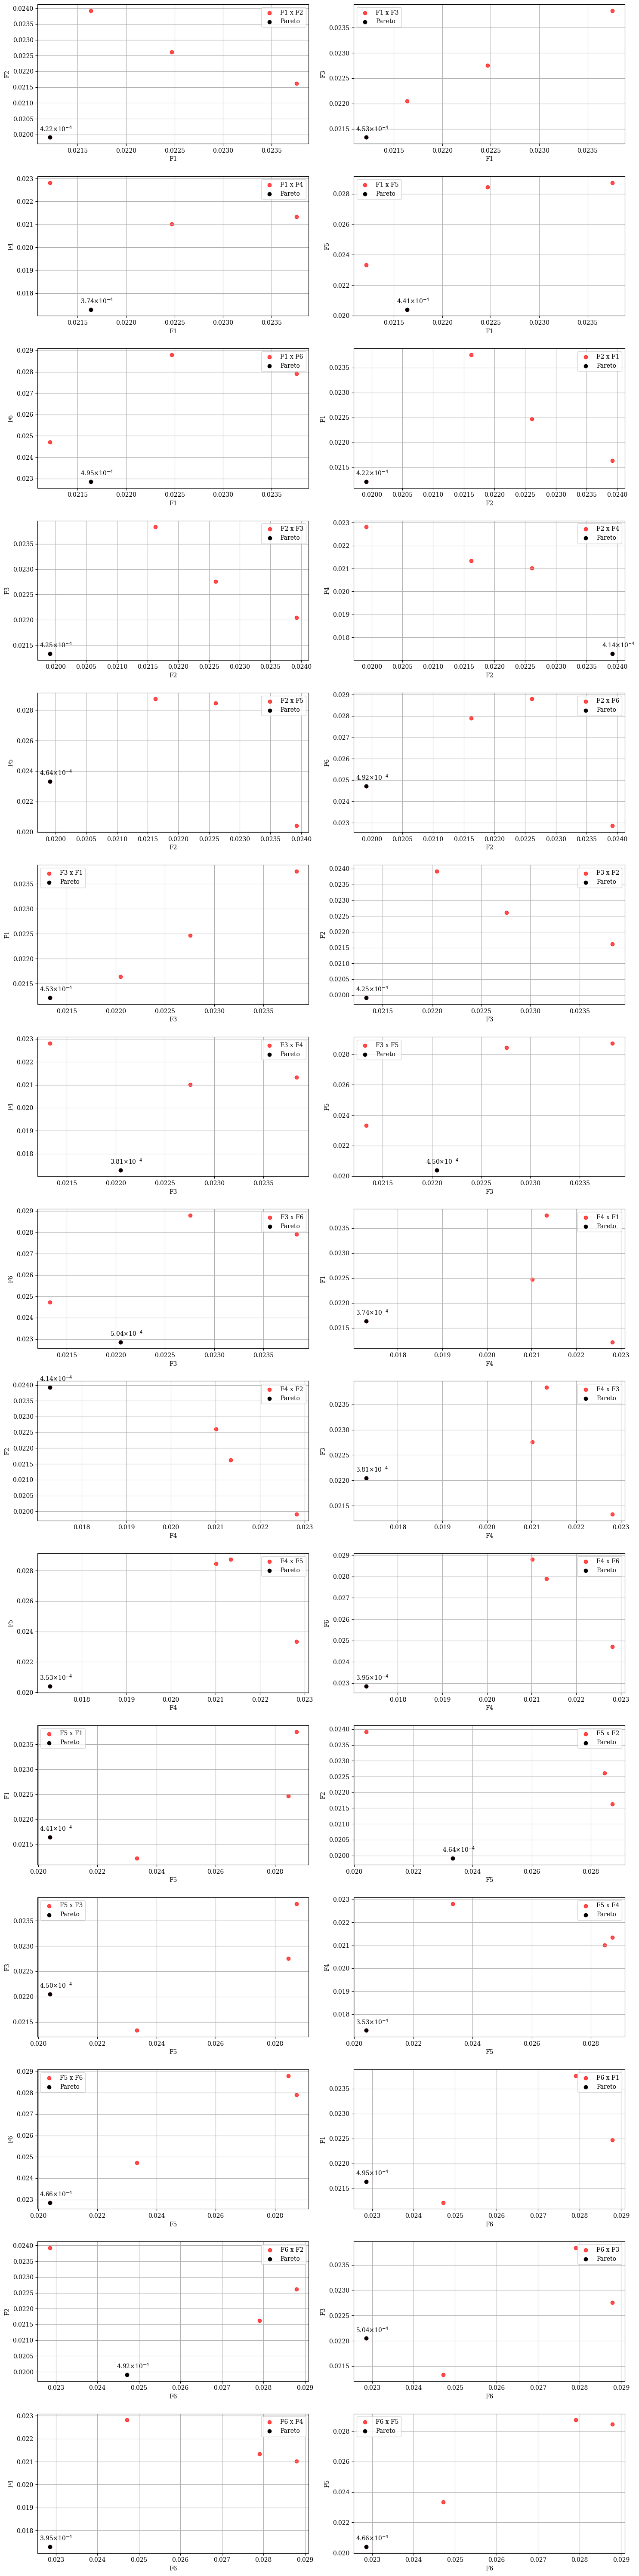

In [ ]:
# Fungsi untuk plot kombinasi
def plot_combination(Fx, Fy, combination_label, ax):
    F_evaluation = Fx * Fy
    argmin_index = np.argmin(F_evaluation)
    min_value = F_evaluation[argmin_index]

    # Ekstrak angka dasar dan eksponen untuk format eksponensial
    mantissa, exponent = f"{min_value:.2e}".split("e")
    mantissa = float(mantissa)
    exponent = int(exponent)

    # Scatter plot
    ax.scatter(Fx, Fy, label=combination_label, color='red', alpha=0.7)
    ax.scatter(Fx[argmin_index], Fy[argmin_index], color='black', label='Pareto')

    # Annotasi titik minimum dengan format LaTeX
    ax.annotate(rf"{mantissa:.2f}×10$^{{{exponent}}}$",
                (Fx[argmin_index], Fy[argmin_index]),
                textcoords="offset points", xytext=(10, 10), ha='center', color='black')

    ax.set_xlabel(combination_label.split(" x ")[0])
    ax.set_ylabel(combination_label.split(" x ")[1])
    ax.legend()
    ax.grid(True)

# Mengambil semua fungsi objektif dalam satu array
F = res.F  # res.F memiliki shape (N_samples, N_objectives)
num_objectives = F.shape[1]  # Jumlah fungsi objektif
objective_labels = [f"F{i+1}" for i in range(num_objectives)]  # Label F1, F2, ..., Fn

# Membuat semua kombinasi termasuk yang terbalik
data_combinations = list(itertools.permutations(range(num_objectives), 2))

# Membuat subplots secara otomatis
num_plots = len(data_combinations)
rows = (num_plots // 2) + (num_plots % 2)  # Menentukan jumlah baris secara dinamis
fig, axes = plt.subplots(rows, 2, figsize=(15, rows * 4))
axes = axes.flatten()

# Plot semua kombinasi
for i, (idx1, idx2) in enumerate(data_combinations):
    plot_combination(F[:, idx1], F[:, idx2], f"{objective_labels[idx1]} x {objective_labels[idx2]}", axes[i])

# Menyembunyikan subplot kosong jika jumlah subplot ganjil
for ax in axes[num_plots:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
F = res.F[idx_optimum]
X = res.X[idx_optimum]

print("Optimum Solution : \nX = %s\nF = %s" % (X, F))

Optimum Solution : 
X = [0.01236362 0.00663111 0.0346729  0.0868886  0.00917762 0.00528889
 0.01231776 0.01194931 0.13634671 2.12265545 0.65072102 0.4198974 ]
F = [0.02121479 0.01990923 0.02133079 0.0228152  0.02333009 0.02471552]


In [ ]:
print("RESULT OF Multi-Objective Optimization (MOO) using NSGA-II:\n---------------------------")
for i in range(n_dim_Y_features):
  print("Value of [{}] (Y{}): {:.6f}".format(Y_features_name[i].upper(),i+1,res.F[0][i]))

print("")

for i in range(n_dim_X_features):
  print("Value of [{}] (X{}): {:.6f}".format(X_features_name[i].upper(),i+1,res.X[0][i]))

RESULT OF Multi-Objective Optimization (MOO) using NSGA-II:
---------------------------
Value of [MORTALITY_RATE] (Y1): 0.022469
Value of [POSITIVE_RATE] (Y2): 0.022610
Value of [RECOVERY_RATE] (Y3): 0.022757
Value of [WORKPLACES] (Y4): 0.021017
Value of [DIFF_IHSG] (Y5): 0.028456
Value of [DIFF_IDR] (Y6): 0.028795

Value of [BOR] (X1): 0.001851
Value of [MEDICAL_PERSONNEL] (X2): 0.003811
Value of [NUMBER_VACCINATIONS] (X3): 0.014435
Value of [RETAIL_RECREATION] (X4): 0.025625
Value of [GROCERY_PHARMACY] (X5): 0.003838
Value of [PARKS] (X6): 0.009866
Value of [TRANSIT_STATIONS] (X7): 0.035981
Value of [RESIDENTIAL] (X8): 0.267272
Value of [INFLATION_YOY] (X9): 0.731745
Value of [BI_RATE] (X10): 2.631297
Value of [BANSOS] (X11): 0.685203
Value of [MINIMUM_WAGE] (X12): 0.410583
